# Soft-GCExplainer

In [1]:
import os,sys

parent = os.path.dirname(os.getcwd())
if parent not in sys.path:
    sys.path.append(parent)
print(parent)
%matplotlib widget

d:\Documents\git\XAI-Cancer-Diagnosis\XAI-Cancer-Diagnosis


---

In [2]:
notebook_settings = {'evaluate_model':False, 'save_concepts': False, 'tsne':False, 'cd':False, 'explain': True}

### Model & Data

In [3]:
# Data

from src.datasets.BACH import BACH
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose, KNNGraph
import torch
import numpy as np


graph_aug_val = Compose([KNNGraph(k=6)])


print('CUDA available: ', torch.cuda.is_available())
print('CUDA device count: ', torch.cuda.device_count())

src_folder = os.path.join(
    "C://Users", "aless", "Documents", "FtT", "data", "BACH_TRAIN")
tid,vid = BACH.get_train_val_ids(src_folder,"graph_orig.txt")
train_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=tid,pre_encoded=True)
val_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=vid,pre_encoded=True)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

print(len(train_loader))
print(len(val_loader))

CUDA available:  True
CUDA device count:  1
77
20


In [4]:
# Model

from src.deep_learning.architectures.cancer_prediction.cancer_gnn import CancerGNN

model = CancerGNN.load_from_checkpoint(os.path.join(parent,"model","GCN.ckpt"),WIDTH=32,HEIGHT=7)

print(model)
print(model.predictor)

CancerGNN(
  (gnn): GCNx(
    (conv): ModuleList(
      (0): GCNConv(32, 32)
      (1): GCNConv(32, 32)
      (2): GCNConv(32, 32)
      (3): GCNConv(32, 32)
      (4): GCNConv(32, 32)
      (5): GCNConv(32, 32)
      (6): GCNConv(32, 32)
    )
    (transform): ModuleList(
      (0): Sequential(
        (0): BatchNorm1d(312, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=312, out_features=32, bias=True)
      )
      (1): Sequential(
        (0): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Dropout(p=0, inplace=False)
        (3): Linear(in_features=32, out_features=32, bias=True)
      )
      (2): Sequential(
        (0): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Dropout(p=0, inplace=False)
        (3): Linear(in_features=32, out_feat

In [5]:
from torch_geometric.data import Batch, Data

def loader_from_one_graph(graph:Data):
    return DataLoader([graph], batch_size=1, shuffle=False)

def extract_graph(batch: Batch, graph_idx: int):
    # Find node indices for the graph
    node_mask = batch.batch == graph_idx

    # Extract the node features for the graph
    x = batch.x[node_mask]

    # Find edge indices for the graph
    edge_mask = node_mask[batch.edge_index[0]] & node_mask[batch.edge_index[1]]
    edge_index = batch.edge_index[:, edge_mask]

    # Re-map edge indices to the new node index space
    edge_index = edge_index - node_mask.nonzero(as_tuple=False).min()

    # If the batch contains other attributes, extract them similarly
    # ...
    y = batch.y[graph_idx]
    pos = batch.pos[node_mask]

    # Create a new Data object for the single graph
    single_graph = Data(x=x, edge_index=edge_index, y=y,pos=pos)
    single_graph.original_image_path = batch.original_image_path[graph_idx] 
    return single_graph

def batch_to_graphs(batch:Batch):
    num_graphs = batch.batch.max().item()
    for ind in range(num_graphs):
        yield extract_graph(batch,ind)

---

### Get Raw Activations

In [6]:
model_width = model.width
print("Model Width: ",model_width)

Model Width:  32


In [7]:
from tqdm import tqdm
from torch import softmax

class RawActivationHook:
    def __init__(self,width,device='cuda'):
        self.activations = torch.zeros(0,width).to(device)
    
    def append_activations(self, model,input, output):
        self.activations = torch.cat((self.activations,output),dim=0)
        
    def __enter__(self):
        self.remove_handle = model.gnn.conv[-1].register_forward_hook(lambda m,i,o:(self.append_activations(m,i,o)))
        return self
    
    def __exit__(self, type, value, traceback):
        self.remove_handle.remove()
        
    def get_activations(self) -> torch.Tensor:
        return self.activations

class ModelForward:
    def __init__(self,model,verbose=False):
        self.model = model
        self.model_width  = model.width
        self.model.eval()
        self.model.to('cuda')
        self.verbose = verbose
        
    def forward_node_level(self,loader):
        # Acquire the activations
        hook = RawActivationHook(self.model_width)


        
        predictions = torch.zeros(0).to('cuda')
        ground = torch.zeros(0).to('cuda')
        
        with hook:
            for batch in tqdm(loader,disable=not self.verbose):
                batch = batch.to('cuda')
                output = model.forward(batch.x,batch.edge_index,batch.batch)
                
                node_probs = softmax(output,dim=1)[batch.batch]
                node_ground = batch.y[batch.batch]
                
                
                predictions = torch.cat([predictions,node_probs])
                ground = torch.cat([ground,node_ground])
            
        raw_activations = hook.get_activations()
        return raw_activations.cpu().detach().numpy(),predictions.cpu().detach().numpy(),ground.cpu().detach().numpy().astype(int)
    
    def forward_graph_level(self,loader):
        predictions = torch.zeros(0).to('cuda')
        ground = torch.zeros(0).to('cuda')
        
        for batch in tqdm(loader,disable=not self.verbose):
            batch = batch.to('cuda')
            output = model.forward(batch.x,batch.edge_index,batch.batch)
            
            graph_probs = softmax(output,dim=1)
            graph_ground = batch.y
            
            predictions = torch.cat([predictions,graph_probs])
            ground = torch.cat([ground,graph_ground])
            
        return predictions.cpu().detach().numpy(),ground.cpu().detach().numpy().astype(int)

forwarder = ModelForward(model)

graph_prob_predictions_train,graph_ground_train = forwarder.forward_graph_level(train_loader)
graph_prob_predictions_val,graph_ground_val = forwarder.forward_graph_level(val_loader)

activations_train,node_predictions_train,node_ground_train  = forwarder.forward_node_level(train_loader)
activations_val,node_predictions_val,node_ground_val = forwarder.forward_node_level(val_loader)

In [8]:
if notebook_settings['evaluate_model']:
    graph_predictions_train = np.argmax(graph_prob_predictions_train,axis=1)
    graph_predictions_val = np.argmax(graph_prob_predictions_val,axis=1)
    print(f"Model accuracy on validation set: {np.sum(graph_predictions_val == graph_ground_val)/len(graph_ground_val)}")
    print(f"Model accuracy on training set: {np.sum(graph_predictions_train == graph_ground_train)/len(graph_ground_train)}")


---
# K Means

In [9]:
import numpy as np
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans

class ConceptDiscoverer:
    def __init__(self,num_concepts,mixture=True,verbose=True,whiten=True,**kwargs) -> None:
        self.k = num_concepts
        if mixture:
            self.gm = BayesianGaussianMixture(n_components=self.k,verbose=verbose,**kwargs)
        else:
            self.gm = MiniBatchKMeans(n_clusters=self.k,verbose=verbose,**kwargs)
            
        self.is_mixture = mixture
        
        self.whiten_act = whiten
        
    def fit(self,activations: np.ndarray):
        self.mu = activations.mean(axis=0)
        self.sigma = activations.std(axis=0)
        
        whitten_activations = self.whiten(activations)        
        self.gm.fit(whitten_activations)
    
    def get_concept_distances(self,activations):
        whittened = self.whiten(activations)
        if self.is_mixture:
            probs = self.gm.predict_proba(whittened)
            #Ensure no zero probabilities
            probs[probs == 0] = 1e-10
            return -np.log(probs)
        else:
            return self.gm.transform(whittened)
            
    def predict(self,activations):
        whitten_activations = self.whiten(activations)
        return self.gm.predict(whitten_activations)
    
    def silouhette_score(self,activations,**kwargs):
        whitten_activations = self.whiten(activations)
        return silhouette_score(whitten_activations,self.gm.predict(whitten_activations),**kwargs)
        
    def whiten(self,obs):
        if(self.whiten_act):
            return (obs - self.mu)/self.sigma
        else:
            return obs



In [10]:
if notebook_settings['cd']:
    sub_sample_size = 1000
    sub_sample = np.random.choice(activations_train.shape[0],sub_sample_size,replace=False)

    num_concepts =64

    cd = ConceptDiscoverer(num_concepts=num_concepts)
    cd.fit(activations_train[sub_sample])
    print(cd.get_concept_distances(activations_train[sub_sample]))

In [11]:
if notebook_settings['cd']:
    #train_concept_probs = cd.predict_proba(activations_train)
    #val_concept_probs = cd.predict_proba(activations_val)

    train_concepts = cd.predict(activations_train)
    val_concepts = cd.predict(activations_val)

## Rejection Sampling
What if we consider only those activations that are we have a certain degree of confidence is in that concept?

In [12]:
def within_acceptance(probabilities:np.ndarray,threshold = 0.99):
    max_prob = probabilities.max(axis=1)
    assert(max_prob.shape[0] == probabilities.shape[0])
    number_surpass = (max_prob > threshold).sum()
    return number_surpass / probabilities.shape[0]

#print("Train: ",within_acceptance(train_concept_probs))
#print("Val: ",within_acceptance(val_concept_probs))

In [13]:
if notebook_settings['save_concepts']:
    np.save("mu.npy",mu)
    np.save("sigma.npy",sigma)

---
# Vizualize Explanations

In [14]:

from sklearn.manifold import TSNE


if notebook_settings['tsne']:
    tsne_sample_size  = 50000
    tsne_sample= np.random.choice(activations_train.shape[0],tsne_sample_size,replace=False)
    position_tsne_sample =TSNE(n_components=2,verbose=2,perplexity = 2000,n_iter=500).fit_transform(activations_train[tsne_sample])


In [15]:

import matplotlib.pyplot as plt
from matplotlib import cm

def plot_tsne_points_with_category(points,classes):
    f = plt.figure(figsize=(10,10))
    # How many different classes are there
    unique_classes = np.unique(classes)
    colours = cm.rainbow(np.linspace(0,1,len(unique_classes)))
    
    # Group the points by their class and then plot all points of the same class at a time
    for i,cl in enumerate(unique_classes):
        points_with_class = (classes==cl)
        v = points[points_with_class]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])

    plt.show()

In [16]:
if notebook_settings['tsne']:
    prediction_tsne_sample = node_predictions_train[tsne_sample].argmax(axis=1)
    ground_tsne_sample = node_ground_train[tsne_sample]
    
    k = 64
    cd = ConceptDiscoverer(num_concepts=k,verbose=False)
    cd.fit(activations_train)
    hard_concept_tsne_sample = cd.predict(activations_train[tsne_sample])

    print(prediction_tsne_sample.shape)
    plot_tsne_points_with_category(position_tsne_sample,ground_tsne_sample)
    plot_tsne_points_with_category(position_tsne_sample,hard_concept_tsne_sample)

---
# Concept Completeness

In [17]:
def one_hot_concept(concept_ids,num_concepts):
    one_hot = np.zeros((len(concept_ids),num_concepts))
    one_hot[np.arange(len(concept_ids)),concept_ids] = 1
    return one_hot

In [18]:


# Takes every observed concept along with the eventual graph prediction and then generates X,Y pairs for training a classifier
def generate_concept_to_prediction_map(model,cd,loader):
    f = ModelForward(model)
    act,pred_prob,ground =  f.forward_node_level(loader)
    
    return cd.predict_proba(act),ground
    

In [19]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

class ConceptNodeCancerPredictor:
    def __init__(self,k):
        self.dt = DecisionTreeClassifier(max_leaf_nodes=k)
        self.k = k
        
    
    def fit(self,concepts,graph_ground):
        self.dt.fit(concepts.reshape(-1,1),graph_ground)

    
    def predict(self,concepts):
        return self.predict_proba(concepts.reshape(-1,1)).argmax(axis=1)
    
    def predict_proba(self,concepts):
        return self.dt.predict_proba(concepts)
    
    def get_concept_prob_of_cancer(self):
        return self.dt.predict_proba(np.arange(self.k).reshape(-1,1))

class ConceptGraphClassPredictor:
    def __init__(self,k,trained_model,trained_concept_discoverer, trained_node_graph_class_predictor):
        self.node_predictor = ConceptNodeCancerPredictor(k)
        self.k = k
        self.forwarder = ModelForward(trained_model)
        self.cd = trained_concept_discoverer
        self.node_predictor = trained_node_graph_class_predictor
        
    def get_graph_concept_distribution(self, graph, rejection_threshold = 0.99):
        act,pred_prob,ground = self.forwarder.forward_node_level(loader_from_one_graph(graph))
        graph_pred = pred_prob[0]
        graph_ground = ground[0]
        #ensure graph ground is flattened
        ground = ground.reshape(-1)

        concept_prob = one_hot_concept(self.cd.predict(act),self.k)
        num_nodes = graph.x.shape[0]
        
        assert concept_prob.shape == (num_nodes,self.k)
        
                
        # Filter out concepts that are not accepted
        accepted = (concept_prob.max(axis=1) > rejection_threshold)
        num_remaining_nodes =  accepted.sum()
        
        assert accepted.shape == (num_nodes,)
        concept_prob = concept_prob[accepted]
        assert concept_prob.shape == (num_remaining_nodes,self.k)
        pred_prob = pred_prob[accepted]
        assert pred_prob.shape == (num_remaining_nodes,4)
        ground = ground[accepted]
        assert ground.shape == (num_remaining_nodes,)
        
        concept_dist = concept_prob.mean(axis=0)
        assert concept_dist.shape == (self.k,)
        
        
        # Graph-pred/ground is the prediction and ground truth for the graph (one value)
        # Node-pred/ground is the prediction and ground truth for the graph but one for each node
        return {'concept-dist':concept_dist,'node-pred':pred_prob, 'node-ground':ground, 'graph-pred':graph_pred, 'graph-ground':graph_ground, 'num-nodes':num_nodes, 'num-nodes-above-threshold':num_remaining_nodes}
    
    def vote_on_graph(self,graph,rejection_threshold = 0.99):
        prediction_info = self.get_graph_concept_distribution(graph,rejection_threshold)
        concept_prob_of_class = self.node_predictor.get_concept_prob_of_cancer()
        # Perform a weighted sum vote
        assert prediction_info['concept-dist'].shape == (self.k,)
        
        weighted_sum = prediction_info['concept-dist'].reshape(-1,1)*concept_prob_of_class
        
        assert concept_prob_of_class.shape == (self.k,4)
        
        assert weighted_sum.shape == (self.k,4)
        vote = weighted_sum.sum(axis=0)
                
        assert vote.shape == (4,)
        prediction_info['concept-vote'] = vote
        return prediction_info


Q: For a particular graph, what concepts are present, how many times for each, and what is the contribution of that concept

In [20]:
if notebook_settings['evaluate_model']:
    cncp = ConceptNodeCancerPredictor(num_concepts)
    cncp.fit(train_concepts,node_ground_train)
    cgcp = ConceptGraphClassPredictor(num_concepts,model,cd,cncp)
    

In [21]:
if notebook_settings['evaluate_model']:
    random_graph_id = np.random.randint(len(val_loader))
    graph = train_loader.dataset[random_graph_id]

    prediction_info = cgcp.vote_on_graph(graph)

    graph_concept_vote = prediction_info['concept-vote']

    graph_ground = prediction_info['graph-ground']
    graph_prediction = prediction_info['graph-pred']

    print("Ground: ",graph_ground)
    print("Prediction: ",graph_prediction.argmax().item(),graph_prediction)
    print("Concept vote: ",graph_concept_vote.argmax(),graph_concept_vote)

In [22]:

# Import cross entropy and accuracy
from sklearn.metrics import accuracy_score,log_loss

# Across a whole dataset, let us evaluate how good the concept_voter is


class ConceptCompleteness:
    def __init__(self, trained_model,num_concepts,verbose = False,rejection_threshold=0.99,**kwargs):
        self.model = trained_model
        self.k = num_concepts
        self.max_samples_for_concept_discovery = kwargs.get('max_samples_for_concept_discovery',10000)
        self.forwarder = ModelForward(self.model,verbose=verbose)
        self.verbose = verbose
        self.rejection_threshold = rejection_threshold
        self.max_iter = kwargs.get('max_iter',200)
       
       
    def from_trainer(self,cd,cncp):
        self.cd = cd
        self.cncp = cncp
        self.cgcp = ConceptGraphClassPredictor(self.k,self.model,self.cd,self.cncp)
         
    def fit(self,loader):
        activations,node_pred,node_ground = self.forwarder.forward_node_level(loader)
        
        self.cd = ConceptDiscoverer(self.k,verbose=self.verbose,max_iter=self.max_iter)
        subset_of_activations = activations[np.random.choice(activations.shape[0],self.max_samples_for_concept_discovery,replace=False)]
        self.cd.fit(subset_of_activations)
        concepts = self.cd.predict(activations)
        
        self.cncp = ConceptNodeCancerPredictor(self.k)
        self.cncp.fit(concepts,node_ground)
            
        self.cgcp = ConceptGraphClassPredictor(self.k,self.model,self.cd,self.cncp)
        
    def evaluate(self,graph):
        prediction_info = self.cgcp.vote_on_graph(graph,self.rejection_threshold)
        return prediction_info['concept-vote'].argmax(),prediction_info['graph-ground']
            
        
    def completeness(self,loader):
        Y_HAT = []
        Y = []
        for batch in tqdm(loader,disable=not self.verbose):
            for graph_id in range(batch.batch.max()):
                graph = extract_graph(batch,graph_id)
                vote,ground = self.evaluate(graph)
                Y_HAT.append(vote)
                Y.append(ground)
        matches = np.equal(np.array(Y),np.array(Y_HAT)).sum()
        return matches/len(Y)
    
                
    



In [23]:
if notebook_settings['evaluate_model']:
    completeness = ConceptCompleteness(model,num_concepts,max_samples_for_concept_discovery=10000)
    completeness.fit(train_loader)
    completeness.completeness(val_loader)

# Determine K
- Perform GM
- Get Concept Completeness
- Plot

In [24]:
if False:
    k_to_inspect = [16,32,64,128,256,512]
    completeness_scores = []

    for k in k_to_inspect:
        completeness = ConceptCompleteness(model,k,max_samples_for_concept_discovery=50000)
        completeness.fit(train_loader)
        score = completeness.completeness(val_loader)
        completeness_scores.append((k,score))   
        print(f"K: {k}, , Score: {score}")    
        

In [25]:
if False:
    print(completeness_scores)
    plt.plot(k_to_inspect,completeness_scores)

## Using Silhoutte Average

In [26]:
def get_n_points(n,data):
    return data[np.random.choice(data.shape[0],n,replace=False)]

In [27]:
if False:
    k_to_inspect = [2,4,8,16,32,64]

    n= 10000
    scores = []
    for k in k_to_inspect:
        for mixture in [True,False]:
            cd = ConceptDiscoverer(k,verbose=False,whiten=True,max_iter=2000,mixture=mixture)
            cd.fit(get_n_points(n,activations_train))
            siho_avg = cd.silouhette_score(activations_train,sample_size=n)
            scores.append((k,mixture,siho_avg))
            print(f"K: {k}, Mixture: {mixture}, Score: {siho_avg}")


# Concept Representation



In [28]:
def create_concept_dist(inp,k):
    concept_dist = np.zeros(k)
    #If graph is a Data
    if type(inp) == Data:
        graph:Data = inp
        for node_id in range(graph.x.shape[0]):
            concept_dist[graph.concepts[node_id]] += 1
    else:
        for node_id in range(inp.shape[0]):
            concept_dist[inp[node_id]] += 1
    return concept_dist

class ConceptGraphGenerator:
    def __init__(self,model_forwarder,concept_discoverer):
        self.forwarder = model_forwarder
        self.cd = concept_discoverer
        
    def generate_concept_graph(self,graph):
        # 1) Get the activations for the graph
        act,pred_prob,ground = self.forwarder.forward_node_level(loader_from_one_graph(graph))
        # 2) Get the concepts
        concepts = self.cd.predict(act)
        graph.concepts = concepts
        graph.activations = act
         


In [29]:
if False:
    num_concepts =50

    cd = ConceptDiscoverer(num_concepts=num_concepts,mixture=False,verbose=False,max_iter=2000)
    max_train_points = 100000
    cd.fit(get_n_points(max_train_points,activations_train))
    cgg = ConceptGraphGenerator(ModelForward(model),cd)

In [30]:
class TopN:
    def __init__(self, n, key=lambda x:x):
        self.n = n
        self.container = []
        self.key = key
        
    def add(self, element,verbose= False):
        old_top = self.container[0] if len(self.container) > 0 else None
        self.container.append(element)
        self.container.sort(reverse=True, key=self.key)
        if len(self.container) > self.n:
            self.container = self.container[:self.n]
        new_top = self.container[0]
        if new_top != old_top and verbose:
            print(f"New top: {self.key(new_top)}")
        # Ensure that all elements are unique
        assert len(set(self.container)) == len(self.container)
        
    
    def get_top(self):
        return self.container
    
    def __str__(self):
        return str(self.container)


In [31]:
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data
import matplotlib.pyplot as plt
def extract_representation(graph,node_id,n):
    # Create a subgraph around the node
    subset,edges,_,_, = k_hop_subgraph(node_id,n,graph.edge_index,relabel_nodes=True)
    #
    subgraph = Data(x=graph.x[subset],edge_index=edges,pos=graph.pos[subset],y=graph.y)
    subgraph.concepts = graph.concepts[subset]
    # Load the image 
    subgraph.original_image_path = graph.original_image_path
    subgraph.node_id = node_id
    return subgraph
        
class ConceptRepresentationExtractor:
    def __init__(self,concept_graph_generator, concept_discoverer,verbose=False):
        self.cgg = concept_graph_generator
        self.cd = concept_discoverer
        self.k = self.cd.k
        self.verbose= verbose
        
    def generate_top_n_representations(self,loader,n,num_hops):
        # Hold a list of the top n representations for each of the k concepts
        top_n_representations = [TopN(n,lambda x:-x[0]) for i in range(self.k)]
        for batch in tqdm(loader,disable=not self.verbose):
            for graph in batch_to_graphs(batch):
                self.cgg.generate_concept_graph(graph)
                for node_id in range(graph.x.shape[0]):
                    subgraph = extract_representation(graph,node_id,num_hops)
                    concept = graph.concepts[node_id]
                    act = graph.activations[node_id].reshape(1,-1)
                    # Get the distance to the concept
                    concept_dist = self.cd.get_concept_distances(act)[0][concept]
                    
                    top_n_representations[concept].add((concept_dist,subgraph))
                    
        # For each concept, get the img of that neighbourhood
        
        return list(map(lambda x: x.get_top(),top_n_representations))
        



In [32]:
def one_example_per_graph(subgraphs:list[Data]):
    # Filter so that only the first example of each graph is kept
    paths = set()
    filtered = []
    for subgraph in subgraphs:
        if subgraph.original_image_path not in paths:
            filtered.append(subgraph)
            paths.add(subgraph.original_image_path)
            
    return filtered

def filter_only_in_class(subgraphs:list[Data],class_id):
    return list(filter(lambda x: x.y.item() == class_id,subgraphs))

In [33]:
if False:
    rep_extractor = ConceptRepresentationExtractor(cgg,cd)
    top_reps = rep_extractor.generate_top_n_representations(train_loader,20,3)



In [34]:
if False:
    print(len(top_reps[0]))
    print(len(one_example_per_graph(ignore_scores(top_reps[0]))))

In [35]:
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph,subgraph
import matplotlib.pyplot as plt


def gen_plot_graph_over_img(graph:Data,ax:plt.Axes,node_colours =None, crop_factor=64, crop_around_nodes=True,padding = 30,hide_nodes = True):

    # Load the tif image
    img = plt.imread(graph.original_image_path)
    # Crop the image
    img = img[crop_factor:-crop_factor,crop_factor:-crop_factor,:]
    # Plot the image on the subplot
    ax.imshow(img)
    
    
    # On top, plot each node & edge
    # Plot the nodes
    if not hide_nodes:
        ax.scatter(graph.pos[:,0],graph.pos[:,1],s=50,c='r' if node_colours is None else node_colours,alpha=0.5)
        # Plot the edges
        for edge in graph.edge_index.T:
            # Plot the edge, but make it faded
            ax.plot(graph.pos[edge,0],graph.pos[edge,1],c='r',alpha=0.5)
        
    # zoom into just the nodes
    if crop_around_nodes:
        ax.set_xlim(graph.pos[:,0].min()-padding,graph.pos[:,0].max()+padding)
        ax.set_ylim(graph.pos[:,1].min()-padding,graph.pos[:,1].max()+padding)
        
    
    
def get_random_subgraph(graph:Data,n=3):
    # Get a random node id
    node_id = np.random.randint(0,graph.num_nodes)
    # Get the subgraph
    subset,edges,_,_ = k_hop_subgraph(node_id,n,graph.edge_index,relabel_nodes=True)
    # Create the subgraph
    subgraph = Data(x=graph.x[subset],edge_index=edges,pos=graph.pos[subset],original_image_path=graph.original_image_path)
    subgraph.graph_id = graph.graph_id
    return subgraph


In [36]:
#import cm
import matplotlib.cm as cm

def plot_all_concept_graphs(graphs:list[Data],hide_nodes = True):
    # Make a grid of figures
    fig,axs = plt.subplots(1,len(graphs),figsize=(7,7))
    k = num_concepts
    # For all k concepts, associate a random colour
    colours  = cm.rainbow(np.linspace(0,1,k))
    
    for i,graph in enumerate(graphs):
        axis = axs[i] if len(graphs) > 1 else axs
        node_colours = colours[graph.concepts]
        print(graph.original_image_path)
        gen_plot_graph_over_img(graph,axis,node_colours=node_colours,hide_nodes=hide_nodes)
    fig.tight_layout()
    fig.show()

def ignore_scores(inp:list[tuple]):
    return list(map(lambda x: x[1],inp))


In [37]:
# Purity
def purity_score(graph,concept):
    # compute what percentage of the nodes are of the concept
    return (graph.concepts == concept).sum()/graph.num_nodes

def get_average_purity(loader,k,rep_extractor):
    top_reps = rep_extractor.generate_top_n_representations(loader,20,2)
    pur = []
    for c in range(k):
        tot = 0
        for i,graph in enumerate(one_example_per_graph(ignore_scores(top_reps[c]))):
            tot += purity_score(graph,c)
        if(len(top_reps[c]) == 0):
            print("No graphs for concept: ",c)
        else:
            pur.append(tot/len(top_reps[c]))
    return np.mean(pur)



    

In [38]:
if notebook_settings['evaluate_model']:
    qty = 50000
    k_to_inspect = [2,4,8,16,32,64,128,256]
    for k in k_to_inspect:
        print("Investigating k: ",k)
        cd = ConceptDiscoverer(k,mixture=False,verbose=False,whiten=True,max_iter=2000)
        cd.fit(get_n_points(qty,activations_train))
        cgg = ConceptGraphGenerator(ModelForward(model),cd)
        rep_extractor = ConceptRepresentationExtractor(cgg,cd)

        # PURITY
        pur = get_average_purity(train_loader,k,rep_extractor)
        # SILO
        
        #siho_avg = cd.silouhette_score(activations_train,sample_size=qty)
        print(f"K: {k}, Purity: {np.mean(pur)}")
        

In [39]:
def train_explanation_resources(num_concepts):
    cd = ConceptDiscoverer(num_concepts=num_concepts,mixture=False,verbose=False,max_iter=2000)
    cd.fit(get_n_points(200000,activations_train))
    train_concepts = cd.predict(activations_train)

    cgg = ConceptGraphGenerator(ModelForward(model),cd)

    rep_extractor = ConceptRepresentationExtractor(cgg,cd)
    top_reps = rep_extractor.generate_top_n_representations(train_loader,5,3)
    cncp = ConceptNodeCancerPredictor(num_concepts)
    cncp.fit(train_concepts,node_ground_train)
    
    return cd,top_reps,cncp

In [40]:
sample = extract_graph(next(iter(val_loader)),2)
sample

Data(x=[839, 312], edge_index=[2, 5034], y=2, pos=[839, 2], original_image_path='C://Users\aless\Documents\FtT\data\BACH_TRAIN\InSitu\is079.tif')

In [94]:
def get_most_exemplary_node(graph:Data,concept_id,cd):
    # Find the node with the highest concept probability
    concept_prob = cd.get_concept_distances(graph.activations)[:,concept_id]
    # Find the node with the highest concept probability
    node_id = int(np.argmin(concept_prob))
    return node_id

class GCExplainer:
    def __init__(self,model_forwarder,concept_discoverer, top_reps,concept_to_pred):
        self.forwarder = model_forwarder
        self.cd = concept_discoverer
        self.k = self.cd.k
        self.top_reps = top_reps
        self.cncp = concept_to_pred
        
    def explain_graph(self,graph:Data):
        # 1) Get the activations for the graph
        pred_prob,y =  self.forwarder.forward_graph_level(loader_from_one_graph(graph))
        y_hat = pred_prob[0].argmax()
        print(f"Predicted class: {y_hat}, Ground truth: {y}")
        act,node_pred_prob,ground = self.forwarder.forward_node_level(loader_from_one_graph(graph))
        # 2) Get the concepts
        concepts = self.cd.predict(act)
        graph.concepts = concepts
        graph.activations = act
        # Print concept dist
        self.print_extracted_concept_dist(graph)
        
        
        top_concepts = self.order_concepts(graph)
        
        concepts_outputted = 0 
        for c in top_concepts:
            if concepts_outputted > 4:
                break
            similiar_graphs = filter_only_in_class(one_example_per_graph(ignore_scores(self.top_reps[c])),y_hat)
            #Select only 3 
            similiar_graphs = similiar_graphs[:3]
            if len(similiar_graphs)!=0:
                print(f"Concept {c}: ")
                exemplary_node = get_most_explempary_node(graph,c,self.cd)
                exemplary_rep = extract_representation(graph,exemplary_node,3)
                fig,axs = plt.subplots(1,1,figsize=(7,7))
                axs.set_title(f"From IMG")
                gen_plot_graph_over_img(exemplary_rep,axs,hide_nodes=True)
                plot_all_concept_graphs(similiar_graphs,hide_nodes=True)
                concepts_outputted += 1
        # Render some graphs
        self.render_graph(graph)
            


        

    

    
    def order_concepts(self,graph:Data,y_hat=0,n=3):
        # Just go for the top 3 most prevelant concepts
        concept_dist = create_concept_dist(graph,self.k)
        top_concepts = np.argsort(concept_dist)[-1::-1]
        return top_concepts        
        
    def print_extracted_concept_dist(self,graph:Data):
        # Tabulate the concepts
        concept_dist = create_concept_dist(graph,self.k)
            
        print("Concept distribution: ")
        for i in range(self.k):
            if concept_dist[i] > 0:
                concept_probs = self.cncp.get_concept_prob_of_cancer()[i]
                print(f"Concept {i}: {concept_dist[i]} - {concept_probs}")
            
        
        
    def render_graph(self,graph:Data):
        fig,ax = plt.subplots(1,1,figsize=(20,20))
        
        gen_plot_graph_over_img(graph,ax,node_colours=graph.concepts,hide_nodes=False)
        ax.axis('off')
        fig.show()

if notebook_settings['explain'] and False:
    explainer = GCExplainer(ModelForward(model),cd,top_reps,cncp)
    explainer.explain_graph(sample)

## LEN

In [42]:
def graph_to_concept_dist(graph:Data,k,forwarder,cd):
    # Get the activations
    activaitons,_,_ = forwarder.forward_node_level(loader_from_one_graph(graph))
    # Get the concepts
    concepts = cd.predict(activaitons)
    # Get the concept distribution
    concept_dist = create_concept_dist(concepts,k)
    return concept_dist
    

def load_dataset(cd,loader,forwarder):
    x = []
    y = []
    # For each graph
    for batch in tqdm(loader):
        for graph in batch_to_graphs(batch):
            # Add to the dataset
            x.append(graph_to_concept_dist(graph,cd.k,forwarder,cd))
            y.append(graph.y)
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    # y = one_hot(y.to(torch.int64),num_classes=classes)
    return x,y



In [163]:
from lens.models.mu_nn import XMuNN
from torch.utils.data import TensorDataset
from torch.nn.functional import one_hot

def apply_to_all_rows(x,func):
    return torch.stack([torch.Tensor(func(row)) for row in x])

class ConceptLogicExplainNetwork:
    def __init__(self,input_concepts,output_classes,hidden_neurons,concept_agg_normalizer) -> None:
        self.input_concepts = input_concepts
        self.output_classes = output_classes
        self.hidden_neurons = hidden_neurons
        self.loss = torch.nn.CrossEntropyLoss()
        self.can = concept_agg_normalizer

    def fit(self,train_concept_dist,train_y,val_concept_dist,val_y,epochs=300,l_r=0.01,l1=0.1):
        
        train_dataset = TensorDataset(apply_to_all_rows(train_concept_dist,self.can),train_y)
        val_dataset = TensorDataset(apply_to_all_rows(val_concept_dist,self.can),val_y)
        self.model = XMuNN(self.output_classes,self.input_concepts,self.hidden_neurons,loss=self.loss,l1_weight=l1)
        self.model.fit(train_dataset,val_dataset,epochs=epochs,l_r=l_r,verbose=True,lr_scheduler=True,early_stopping=True)

    def predict(self,all_dist,all_y,concept_dist,y_hat,simplify=True):
        return self.model.get_local_explanation(all_dist,all_y,concept_dist,target_class=y_hat,simplify=simplify)
        
    
    def evaluate(self,x_dist,y):
        return self.model.evaluate(TensorDataset(apply_to_all_rows(x_dist,self.can),y))
    

        
def top_k_norm(dist,k):
    low_concepts = np.argsort(dist)
    high_concepts = low_concepts[-k:]
    output = np.zeros(dist.shape)
    output[high_concepts] = 1
    return output

def above_threshold_norm(dist,threshold):
    return ((dist/dist.sum()) > threshold).int().float()

def sum_norm(dist):
    return dist/dist.sum()


harden = lambda x: above_threshold_norm(x,0)







In [77]:
def plot_example_reps_for_concepts(top_rep,concept_id,cl=None):
    top = top_rep[concept_id]
    graphs = one_example_per_graph(ignore_scores(top))
    if cl is not None:
        graphs = filter_only_in_class(graphs,cl)
    plot_all_concept_graphs(graphs,hide_nodes=True)

In [78]:
if False:
    
    num_concepts = 64
    cd,top_reps,_ = train_explanation_resources(num_concepts)
    train_concepts_dist,train_y = load_dataset(cd,train_loader,ModelForward(model))
    val_concepts_dist,val_y = load_dataset(cd,val_loader,ModelForward(model))
    
    normalizers = {'top_1':lambda x: top_k_norm(x,1),
               'top_3':lambda x: top_k_norm(x,3),
               'top_5':lambda x: top_k_norm(x,5),
               'top_10':lambda x: top_k_norm(x,10),
               'harden':harden,
               'above_0.05':lambda x: above_threshold_norm(x,0.05),
               'above_0.1':lambda x: above_threshold_norm(x,0.1),
               'above_0.2':lambda x: above_threshold_norm(x,0.2),
               'sum_norm': sum_norm}
    scores = {}
    epochs =1000
    for name,func in normalizers.items():
        len = ConceptLogicExplainNetwork(num_concepts,4,[32],func)
        len.fit(train_concepts_dist,train_y,val_concepts_dist,val_y,epochs=epochs)
        score = len.evaluate(val_concepts_dist,val_y)
        scores[name] = score
        print(f"Score for {name}: {score}")
    print(scores)

In [79]:
num_concepts = 256
cd,top_reps,_ = train_explanation_resources(num_concepts)
train_concepts_dist,train_y = load_dataset(cd,train_loader,ModelForward(model))
val_concepts_dist,val_y = load_dataset(cd,val_loader,ModelForward(model))

100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


In [171]:
clen = ConceptLogicExplainNetwork(num_concepts,4,[],harden)
clen.fit(train_concepts_dist,train_y,val_concepts_dist,val_y,epochs=500,l1=1)
print(clen.evaluate(val_concepts,val_y))


Epoch: 1/500, Loss: 323.996, Tr_acc: 33.48, Val_acc: 29.31, best_e: -1
Epoch: 2/500, Loss: 237.055, Tr_acc: 31.30, Val_acc: 27.59, best_e: -1
Epoch: 3/500, Loss: 166.859, Tr_acc: 29.57, Val_acc: 20.69, best_e: -1
Epoch: 4/500, Loss: 115.779, Tr_acc: 24.78, Val_acc: 18.97, best_e: -1
Epoch: 5/500, Loss: 81.877, Tr_acc: 15.65, Val_acc: 13.79, best_e: -1
Epoch: 6/500, Loss: 66.289, Tr_acc: 10.00, Val_acc: 13.79, best_e: -1
Epoch: 7/500, Loss: 69.715, Tr_acc: 10.00, Val_acc: 15.52, best_e: -1
Epoch: 8/500, Loss: 83.644, Tr_acc: 16.09, Val_acc: 15.52, best_e: -1
Epoch: 9/500, Loss: 86.602, Tr_acc: 19.57, Val_acc: 20.69, best_e: -1
Epoch: 10/500, Loss: 83.419, Tr_acc: 23.48, Val_acc: 25.86, best_e: -1
Epoch: 11/500, Loss: 75.522, Tr_acc: 29.57, Val_acc: 29.31, best_e: -1
Epoch: 12/500, Loss: 65.280, Tr_acc: 29.13, Val_acc: 29.31, best_e: -1
Epoch: 13/500, Loss: 53.260, Tr_acc: 31.30, Val_acc: 32.76, best_e: -1
Epoch: 14/500, Loss: 46.058, Tr_acc: 34.35, Val_acc: 36.21, best_e: -1
Epoch: 15/5

In [143]:
sample = extract_graph(next(iter(val_loader)),2)

ConceptGraphGenerator(ModelForward(model),cd).generate_concept_graph(sample)

sample_concept_dist = torch.Tensor(graph_to_concept_dist(sample,num_concepts,ModelForward(model),cd))
graph_y_hat,graph_y =  ModelForward(model).forward_graph_level(loader_from_one_graph(sample))
sample_y = int(graph_y[0])
print(f"Predicted class: {graph_y_hat.argmax()}, Ground truth: {graph_y}")

Predicted class: 3, Ground truth: [3]


In [131]:

clen.predict(train_concepts_dist,train_y,sample_concept_dist,sample_y)


'~feature0000000007 & ~feature0000000022 & feature0000000030 & feature0000000050 & ~feature0000000052 & ~feature0000000058 & ~feature0000000105 & feature0000000114 & ~feature0000000120 & ~feature0000000127 & feature0000000157 & ~feature0000000161 & ~feature0000000167 & ~feature0000000170 & ~feature0000000171 & ~feature0000000172 & feature0000000188 & ~feature0000000220 & ~feature0000000223 & ~feature0000000244'

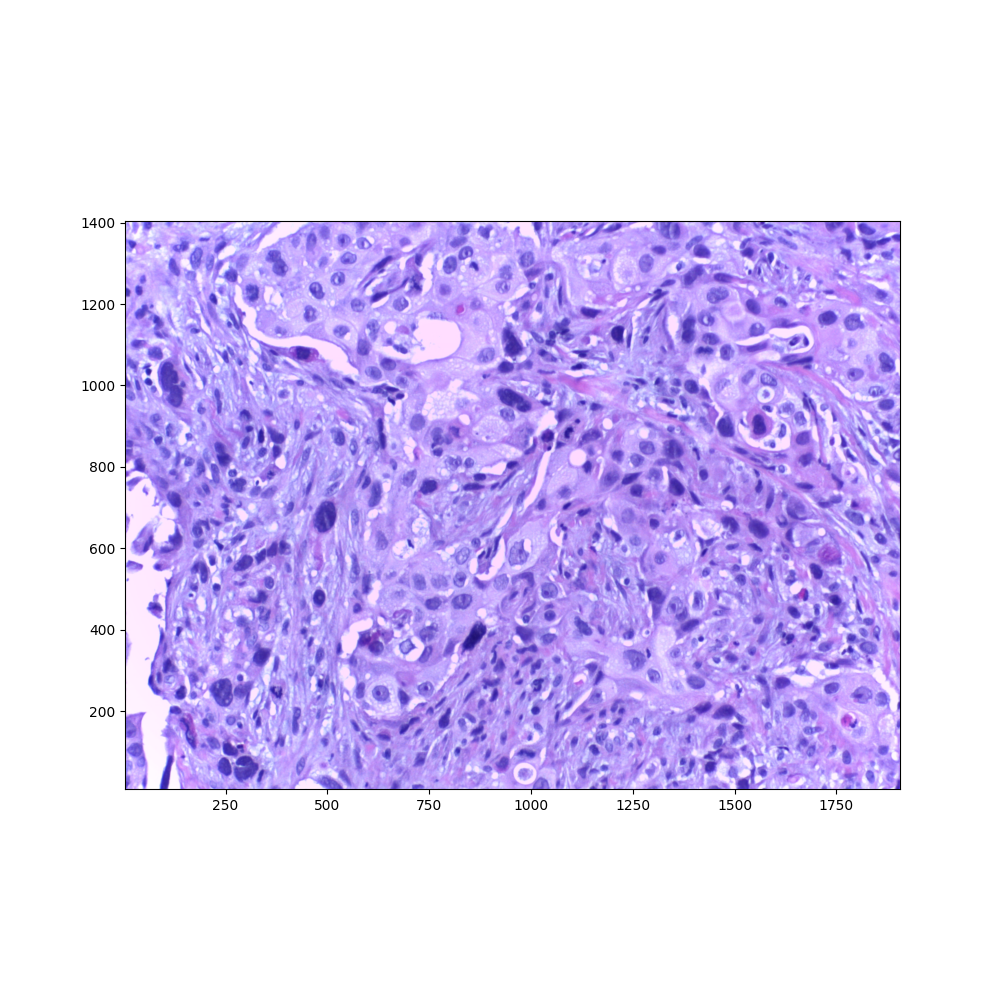

In [130]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
gen_plot_graph_over_img(sample,ax,hide_nodes=True)


ValueError: Number of columns must be a positive integer, not 0

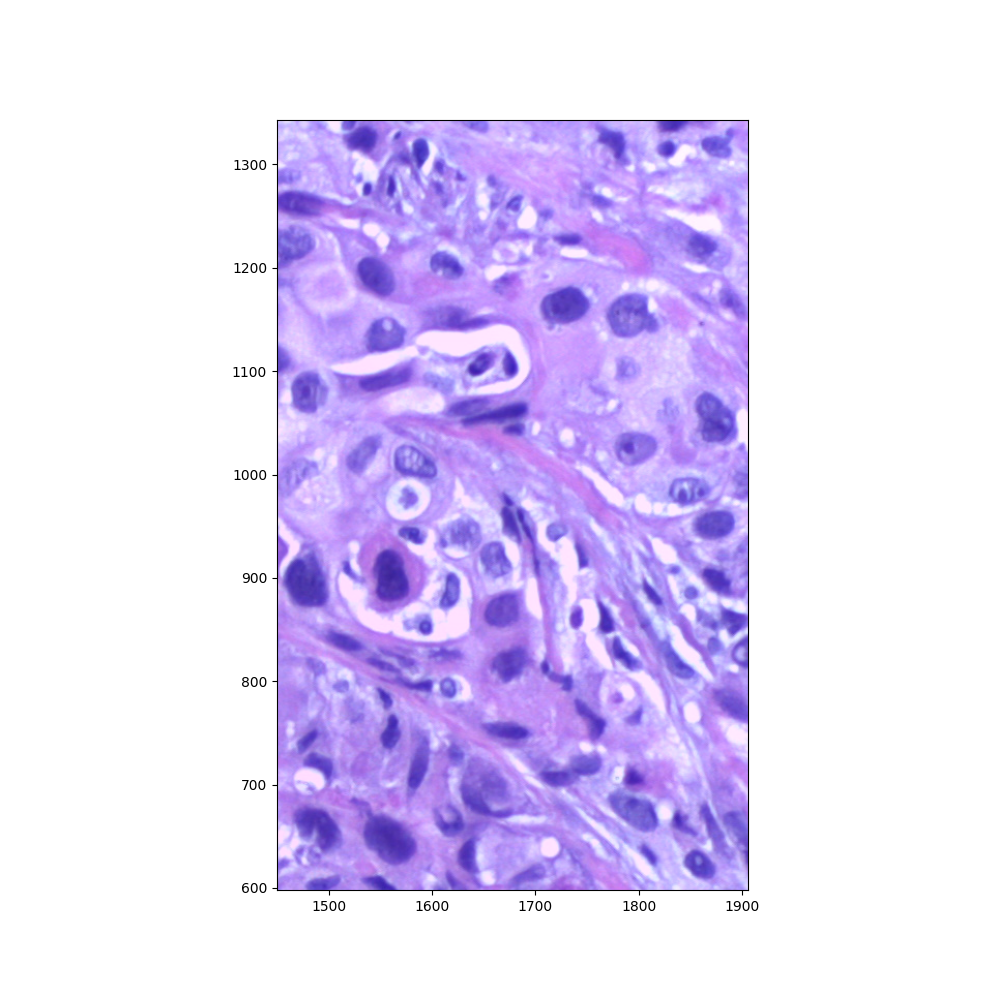

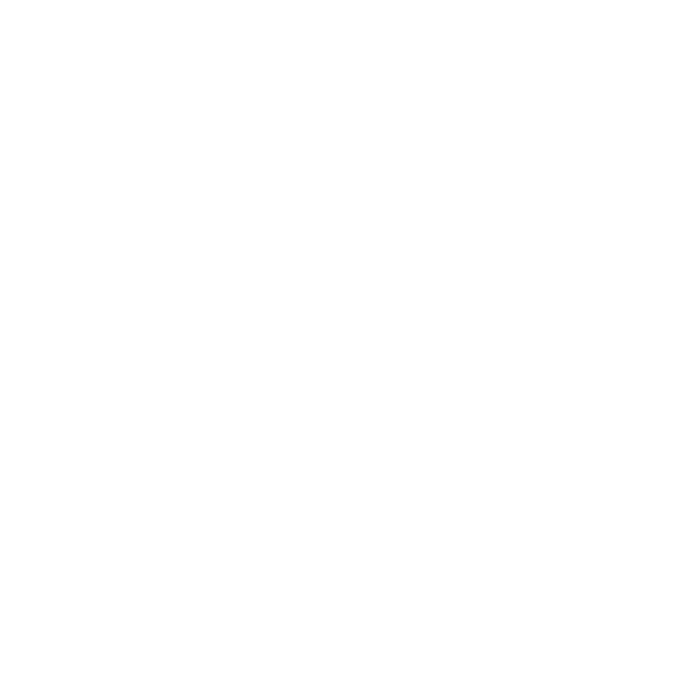

In [142]:
c = 120

# Plot concept from image
cgg = ConceptGraphGenerator(ModelForward(model),cd)

node = get_most_exemplary_node(sample,c,cd)
rep_to_show: Data = extract_representation(sample,node,5)

fig,ax = plt.subplots(1,1,figsize=(10,10))
gen_plot_graph_over_img(rep_to_show,ax,hide_nodes=True)


# Plot Exemplary
plot_example_reps_for_concepts(top_reps,c,cl=sample_y)

is055

## Thoughts:
- Using KMeans vs Gaussian Mixture Model 
- Euclidean vs Malahnobis distances